Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto.
Descarga los datos y haz el remuestreo por una hora.
Analiza los datos
Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.
Descripción de los datos
Los datos se almacenan en el archivo taxi.csv. El número de pedidos está en la columna num_orders.

Preparación

In [92]:
# Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [93]:
# Visualizacion de datos

data = pd.read_csv('taxi.csv')
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [94]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [95]:
# Cambiar la columna datetime de object a datetime

data['datetime'] = pd.to_datetime(data['datetime'])


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [97]:
# evaluar si hay valores nulos 

data.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [98]:
# Establece como  índice la columna datetime

data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0] )
data.sort_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [99]:
# Agrupar por hora 

df_hourly = data.resample('1H').sum()
df_hourly

C:\Users\dpand\AppData\Local\Temp\ipykernel_2344\2464345186.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Análisis

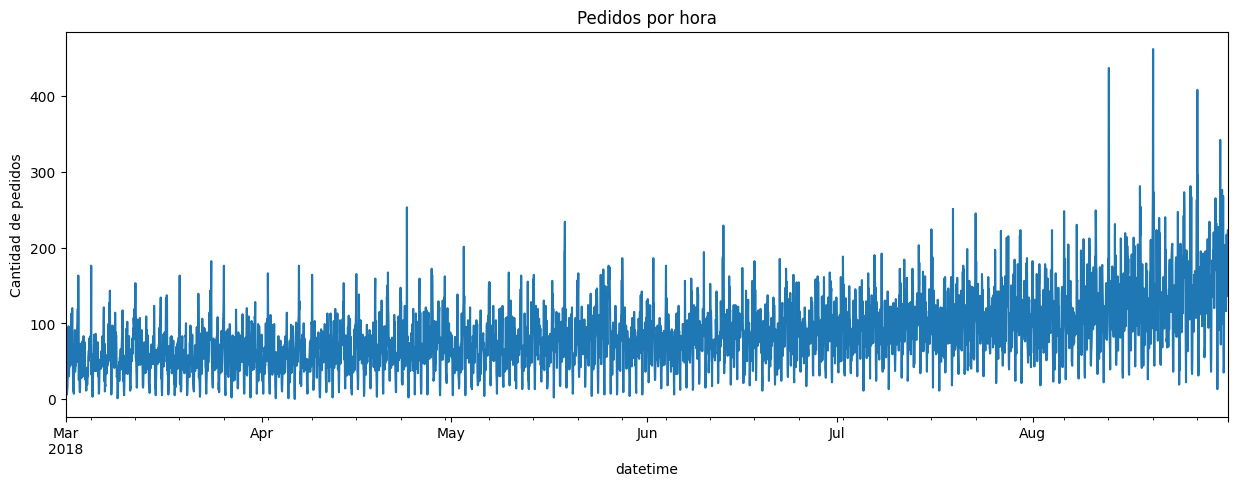

In [100]:
# Grafica

df_hourly['num_orders'].plot(figsize=(15,5))
plt.title('Pedidos por hora')
plt.ylabel('Cantidad de pedidos')
plt.show()

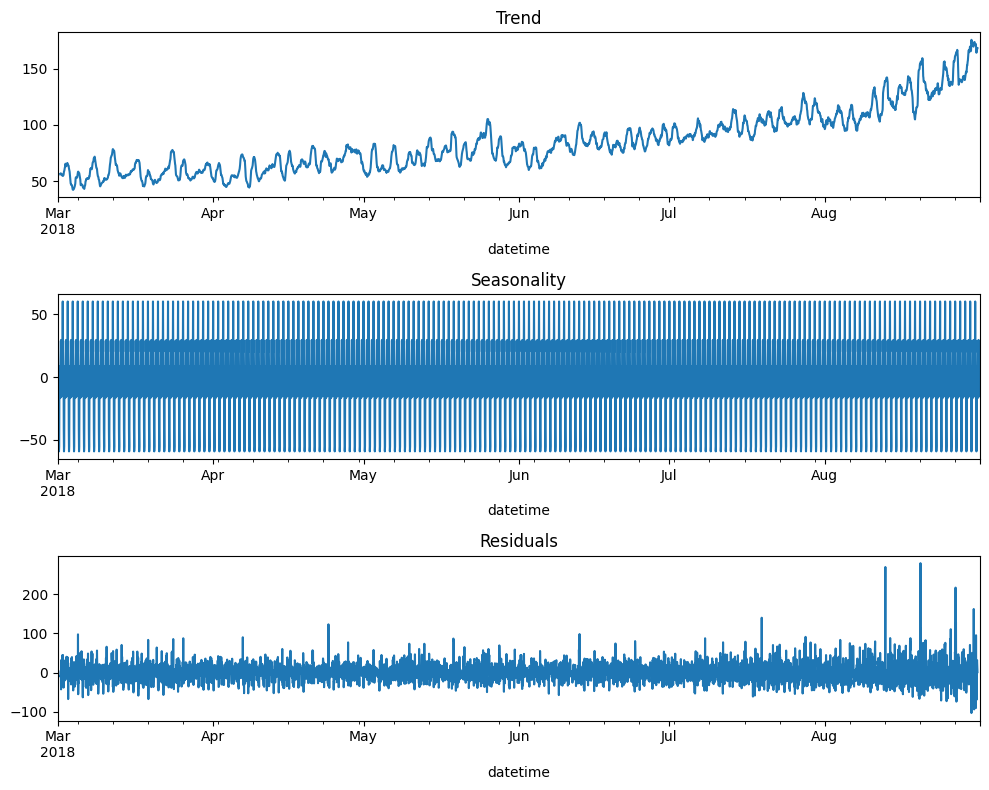

In [101]:
# grafica de tendencia y estacionalidad

decomposed = seasonal_decompose(df_hourly)

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [110]:
def make_features(data, max_lag):
        
    for lag in range(1, max_lag + 1):
        df_hourly['lag_{}'.format(lag)] = df_hourly['num_orders'].shift(lag)

  
make_features(df_hourly, 12)

In [109]:
print(df_hourly)

                     num_orders  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
datetime                                                                    
2018-03-01 00:00:00         124    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85  124.0    NaN    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00          71   85.0  124.0    NaN    NaN    NaN    NaN   
2018-03-01 03:00:00          66   71.0   85.0  124.0    NaN    NaN    NaN   
2018-03-01 04:00:00          43   66.0   71.0   85.0  124.0    NaN    NaN   
...                         ...    ...    ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136  207.0  217.0  197.0  116.0  133.0  166.0   
2018-08-31 20:00:00         154  136.0  207.0  217.0  197.0  116.0  133.0   
2018-08-31 21:00:00         159  154.0  136.0  207.0  217.0  197.0  116.0   
2018-08-31 22:00:00         223  159.0  154.0  136.0  207.0  217.0  197.0   
2018-08-31 23:00:00         205  223.0  159.0  154.0  136.0  207.0  217.0   

In [114]:
# Segmentacion de datos

train, test = train_test_split(df_hourly, shuffle=False, test_size=0.1)
train = train.dropna()

x_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
x_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']


In [115]:
# Modelo de  Regresión Lineal

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RECM del modelo Regresión Lineal: {rmse:.2f}")

RECM del modelo Regresión Lineal: 6.71


In [113]:
#  Modelo de Random Forest

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Calcular RECM
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RECM del modelo Random Forest:  {rmse:.2f}")

RECM del modelo Random Forest:  6.60


In [116]:
# Modelo LightGBM

model = LGBMRegressor(n_estimators=50, learning_rate=0.1, max_depth=10)   
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
    
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RECM del modelo LightGBM: {rmse:.2f}")  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4550
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 24
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RECM del modelo LightGBM: 6.56


In [117]:
# Modelo Catboost

model = CatBoostRegressor(
        iterations=50,
        learning_rate=0.1,
        depth=5,
        verbose=0 )
        
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RECM del modelo Catboost: {rmse:.2f}")  

RECM del modelo Catboost: 6.81


Conclusión

LightGBM fue el modelo más preciso, con un RECM de 6.56, el más bajo entre todos los modelos evaluados. Random Forest también obtuvo un buen rendimiento con 6.60, muy cercano a LightGBM. La Regresión Lineal, a pesar de ser un modelo simple, logró un RECM (6.71). CatBoost obtuvo el mayor RECM (6.81) entre los modelos probados, aunque sigue siendo un valor bajo y aceptable. 

Se recomienda utilizar LightGBM como modelo final para predecir la cantidad de pedidos de taxis por hora, ya que ofrece la mayor precisión, manteniéndose muy por debajo del umbral de 48.